# LSTM

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Step0：定义LSTM模型类、制作Dataloader

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y
    

class ECGClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(ECGClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # LSTM 输出大小：(batch_size, seq_length, hidden_dim)
        out, (hn, cn) = self.lstm(x)
        # 选择最后一个时间步的输出
        out = out[:, -1, :]
        out = self.fc(out)
        return out

## Step2：定义模型、损失函数、优化器以及训练数据

In [4]:
import numpy as np 

# 检查CUDA是否可用，如果可用则使用CUDA，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 读取数据集
data_train = np.loadtxt('../ECG5000/data/ECG5000_TEST.txt')

# 获取data和label
data, labels = data_train[:, 1:], data_train[:, 0]-1.0 # 这里-1.0是为了将标签从0开始

# 转换成tensor张量
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.long)

# 使用 np.unique 获取所有唯一标签
unique_labels = np.unique(labels)

# 获取唯一标签的数量
num_unique_labels = len(unique_labels)
# print(num_unique_labels)

# Create dataset and dataloader
dataset = CustomDataset(data, labels)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# model = ECGClassifier(input_dim=140, hidden_dim=64, num_layers=4, num_classes=num_unique_labels)
model = ECGClassifier(input_dim=140, hidden_dim=4, num_layers=2, num_classes=num_unique_labels)

model.to(device)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

Using cuda device


## 打印模型结构、参数

In [5]:
for name, layer in model.named_children():
    print(f"Layer: {name}")
    print(f"Structure: {layer}")
    if hasattr(layer, 'activation'):
        print(f"Activation Function: {layer.activation}")
    print()
    
lstm_params = list(model.lstm.named_parameters())
for name, param in lstm_params:
    print(f"{name}: {param.size()}")
    
print(" \n--------------------------------\n")
  
total_params = 0
for name, param in model.named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"Layer: {name} | Size: {param.size()} | Number of Parameters: {num_params}")

print(" \n--------------------------------\n")

print(f"模型总参数量: {total_params * 4} Bytes ")

Layer: lstm
Structure: LSTM(140, 4, num_layers=2, batch_first=True)

Layer: fc
Structure: Linear(in_features=4, out_features=5, bias=True)

weight_ih_l0: torch.Size([16, 140])
weight_hh_l0: torch.Size([16, 4])
bias_ih_l0: torch.Size([16])
bias_hh_l0: torch.Size([16])
weight_ih_l1: torch.Size([16, 4])
weight_hh_l1: torch.Size([16, 4])
bias_ih_l1: torch.Size([16])
bias_hh_l1: torch.Size([16])
 
--------------------------------

Layer: lstm.weight_ih_l0 | Size: torch.Size([16, 140]) | Number of Parameters: 2240
Layer: lstm.weight_hh_l0 | Size: torch.Size([16, 4]) | Number of Parameters: 64
Layer: lstm.bias_ih_l0 | Size: torch.Size([16]) | Number of Parameters: 16
Layer: lstm.bias_hh_l0 | Size: torch.Size([16]) | Number of Parameters: 16
Layer: lstm.weight_ih_l1 | Size: torch.Size([16, 4]) | Number of Parameters: 64
Layer: lstm.weight_hh_l1 | Size: torch.Size([16, 4]) | Number of Parameters: 64
Layer: lstm.bias_ih_l1 | Size: torch.Size([16]) | Number of Parameters: 16
Layer: lstm.bias_hh_l

## Step3：开始模型训练

In [6]:
# 定义训练过程
def train_model(model, train_loader, criterion, optimizer, num_epochs, device='cpu'):
    for epoch in range(num_epochs):
        for i, (signals, labels) in enumerate(train_loader):
            # 前向传播
            # print(signals.shape)
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                
# 开始执行模型训练
train_model(model, train_loader, criterion, optimizer, num_epochs=80, device=device)

Epoch [1/80], Step [100/282], Loss: 1.3987
Epoch [1/80], Step [200/282], Loss: 1.3803
Epoch [2/80], Step [100/282], Loss: 1.1938
Epoch [2/80], Step [200/282], Loss: 1.2035
Epoch [3/80], Step [100/282], Loss: 1.0764
Epoch [3/80], Step [200/282], Loss: 1.0950
Epoch [4/80], Step [100/282], Loss: 0.8203
Epoch [4/80], Step [200/282], Loss: 0.7030
Epoch [5/80], Step [100/282], Loss: 0.6661
Epoch [5/80], Step [200/282], Loss: 0.5727
Epoch [6/80], Step [100/282], Loss: 0.6226
Epoch [6/80], Step [200/282], Loss: 0.5998
Epoch [7/80], Step [100/282], Loss: 0.5346
Epoch [7/80], Step [200/282], Loss: 0.6361
Epoch [8/80], Step [100/282], Loss: 0.3381
Epoch [8/80], Step [200/282], Loss: 0.4885
Epoch [9/80], Step [100/282], Loss: 0.4375
Epoch [9/80], Step [200/282], Loss: 0.3352
Epoch [10/80], Step [100/282], Loss: 0.4534
Epoch [10/80], Step [200/282], Loss: 0.4365
Epoch [11/80], Step [100/282], Loss: 0.1767
Epoch [11/80], Step [200/282], Loss: 0.2519
Epoch [12/80], Step [100/282], Loss: 0.5259
Epoch 

## Step4：测试集验证

In [7]:
## Step4：测试集验证
# 读取测试数据集
data_test = np.loadtxt('../ECG5000/data/ECG5000_TEST.txt')

# 获取data和label
test_data, test_labels = data_train[:, 1:], data_train[:, 0]-1.0
test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_labels, dtype=torch.long)

test_dataset = CustomDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()

correct = 0
total = 0
total_loss = 0.0

y_pred = []
y_true = []

with torch.no_grad():  # 关闭梯度计算
    for data, labels in test_loader:
        if device.type == 'cuda':
            data, labels = data.to(device), labels.to(device)  # Move data and labels to the device
        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)  # 计算损失
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        y_pred.extend(predicted.cpu().numpy())  # 收集预测结果
        y_true.extend(labels.cpu().numpy())     # 收集真实标签

average_loss = total_loss / len(test_loader)
accuracy = correct / total
print(f'Accuracy of the model on the test data: {100 * accuracy}%')
print(f'Average loss: {average_loss}')

Accuracy of the model on the test data: 95.42222222222222%
Average loss: 0.16117828369176843


## Step5: 绘制confusion matrix


C:\Users\Charles\AppData\Local\Temp\ipykernel_9336\3463582496.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(np.unique(y_pred)))
C:\Users\Charles\AppData\Local\Temp\ipykernel_9336\3463582496.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(np.unique(y_pred)))


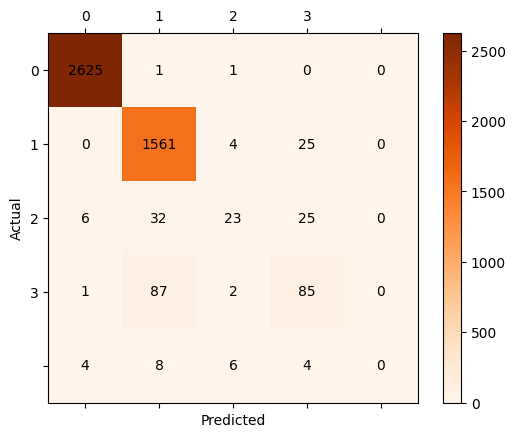

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

# 使用matplotlib绘制混淆矩阵
# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap=plt.cm.Oranges)  # 选择颜色映射

# 为图添加颜色条
plt.colorbar(cax)

# 设置坐标轴
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticklabels([''] + list(np.unique(y_pred)))
ax.set_yticklabels([''] + list(np.unique(y_pred)))

# 在混淆矩阵的各个单元格中添加数值标签
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black')

# 显示图表
plt.show()

## numpy实现LSTM前向推理过程

基于numpy实现推理的流程，很容易实现基于C代码实现LSTM的前向推理。

### LSTM推理公式

\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}

In [9]:
# 基于numpy实现的LSTM前向推理

import numpy as np

def extract_parameters(model):
    parameters = {}
    # LSTM层的权重和偏置
    parameters['lstm_weights_ih'] = [p.data.numpy() for p in model.lstm.parameters()][0::4]
    parameters['lstm_weights_hh'] = [p.data.numpy() for p in model.lstm.parameters()][1::4]
    parameters['lstm_biases_ih'] = [p.data.numpy() for p in model.lstm.parameters()][2::4]
    parameters['lstm_biases_hh'] = [p.data.numpy() for p in model.lstm.parameters()][3::4]
    
    # 全连接层的权重和偏置
    parameters['fc_weights'] = model.fc.weight.data.numpy()
    parameters['fc_biases'] = model.fc.bias.data.numpy()
    
    return parameters

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def lstm_forward(x, params, hidden_dim, num_layers):
    seq_len, input_dim = x.shape
    h = np.zeros((num_layers, hidden_dim))
    c = np.zeros((num_layers, hidden_dim))
    
    # for t in range(seq_len):
    for layer in range(num_layers):        
        print(f'执行第{layer}层')
        if layer == 0:
            input, hx = x, np.zeros((1, hidden_dim))
        else:
            input, hx = h[layer-1], np.zeros((1, hidden_dim))
        
        wi, wf, wg, wo = np.split(params['lstm_weights_ih'][layer], 4)
        bi, bf, bg, bo = np.split(params['lstm_biases_ih'][layer], 4)
        whi, whf, whg, who = np.split(params['lstm_weights_hh'][layer], 4)
        bhi, bhf, bhg, bho = np.split(params['lstm_biases_hh'][layer], 4)
        
        # print(params['lstm_weights_ih'][layer].shape)
        # print(params['lstm_biases_ih'][layer].shape)
        # print(params['lstm_weights_hh'][layer].shape)
        # print(params['lstm_biases_hh'][layer].shape)
        # print(wi.shape, bi.shape, whi.shape, bhi.shape)

        # i = sigmoid(np.dot(input, wi.T) + bi + np.dot(hx, whi.T) + bhi)
        # f = sigmoid(np.dot(input, wf.T) + bf + np.dot(hx, whf.T) + bhf)
        # g = tanh(np.dot(input, wg.T) + bg + np.dot(hx, whg.T) + bhg)
        # o = sigmoid(np.dot(input, wo.T) + bo + np.dot(hx, who.T) + bho)
        
        # 进一步简化
        i = sigmoid(np.dot(input, wi.T) + bi + bhi)
        f = sigmoid(np.dot(input, wf.T) + bf + bhf)
        g = tanh(np.dot(input, wg.T) + bg + bhg)
        o = sigmoid(np.dot(input, wo.T) + bo + bho)
        
        c[layer] = f * c[layer] + i * g
        h[layer] = o * tanh(c[layer])
    
    return h[-1]  # Returning the last hidden state of the last layer

def fc_forward(h, params):
    return np.dot(params['fc_weights'], h) + params['fc_biases']

def model_forward(x, params, num_layers):
    h = lstm_forward(x, params, params['fc_weights'].shape[1], num_layers)
    output = fc_forward(h, params)
    return output

In [10]:
import numpy as np

# 打印模型的权重
for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")
print('--------------------------------------------')

# 将模型权重转换为 NumPy 数组
params = {name: param.detach().cpu().numpy() for name, param in model.named_parameters()}

params = extract_parameters(model)

# 读取测试数据集
data_test = np.loadtxt('../ECG5000/data/ECG5000_TEST.txt')

# 获取data和label
test_data, test_labels = data_test[:, 1:], data_test[:, 0]-1.0

# 随机选择一个测试样本
rd_idx = np.random.randint(test_labels.shape[0])
rd_idx = 100
input_data = test_data[rd_idx,:]

# def print_cpp_format(array, array_name="arr"):
#     # 将数组元素转换为字符串列表
#     elements = map(str, array)
#     # 拼接所有元素为一个逗号分隔的字符串
#     elements_str = ', '.join(elements)
#     # 打印C++风格的数组初始化代码
#     print(f"double {array_name}[] = {{{elements_str}}};")

# print_cpp_format(input_data)

input_data = input_data.reshape([1,140])

# 执行 LSTM 前向传播
output = model_forward(input_data, params, model.lstm.num_layers)

# 使用原本model进行推理
model.eval()
input_data = torch.tensor(input_data.reshape([1,1,140]), dtype=torch.float32).to(device=device)
output2 = model(input_data)
output2 = output2.detach().cpu().numpy()

# 打印两种推理方式的结果，可以看到是一致的
print(output, '\n' , output2)

# 预测label
predict_ = np.argmax(output)

print(f"预测类型：{predict_}, 真值： {test_labels[rd_idx]}")

lstm.weight_ih_l0: torch.Size([16, 140])
lstm.weight_hh_l0: torch.Size([16, 4])
lstm.bias_ih_l0: torch.Size([16])
lstm.bias_hh_l0: torch.Size([16])
lstm.weight_ih_l1: torch.Size([16, 4])
lstm.weight_hh_l1: torch.Size([16, 4])
lstm.bias_ih_l1: torch.Size([16])
lstm.bias_hh_l1: torch.Size([16])
fc.weight: torch.Size([5, 4])
fc.bias: torch.Size([5])
--------------------------------------------


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:

def save_lstm_parameters(weights, filename):
    # 分割权重和偏置
    wi, wf, wg, wo = np.split(weights['lstm.weight_ih_l0'], 4)
    bi, bf, bg, bo = np.split(weights['lstm.bias_ih_l0'], 4)
    whi, whf, whg, who = np.split(weights['lstm.weight_hh_l0'], 4)
    bhi, bhf, bhg, bho = np.split(weights['lstm.bias_hh_l0'], 4)
    
    # 打开文件进行写入
    with open(filename, 'w') as file:
        # 写入输入门权重和偏置
        file.write("Input Gate Weights (wi):\n")
        file.write(np.array2string(wi) + "\n")
        file.write("Input Gate Bias (bi):\n")
        file.write(np.array2string(bi) + "\n")
        
        # 写入遗忘门权重和偏置
        file.write("Forget Gate Weights (wf):\n")
        file.write(np.array2string(wf) + "\n")
        file.write("Forget Gate Bias (bf):\n")
        file.write(np.array2string(bf) + "\n")
        
        # 写入候选门权重和偏置
        file.write("Candidate Gate Weights (wg):\n")
        file.write(np.array2string(wg) + "\n")
        file.write("Candidate Gate Bias (bg):\n")
        file.write(np.array2string(bg) + "\n")
        
        # 写入输出门权重和偏置
        file.write("Output Gate Weights (wo):\n")
        file.write(np.array2string(wo) + "\n")
        file.write("Output Gate Bias (bo):\n")
        file.write(np.array2string(bo) + "\n")
        
        # 写入隐藏状态权重和偏置
        file.write("Hidden State Weights (whi, whf, whg, who):\n")
        file.write(np.array2string(whi) + "\n")
        file.write(np.array2string(whf) + "\n")
        file.write(np.array2string(whg) + "\n")
        file.write(np.array2string(who) + "\n")
        
        file.write("Hidden State Biases (bhi, bhf, bhg, bho):\n")
        file.write(np.array2string(bhi) + "\n")
        file.write(np.array2string(bhf) + "\n")
        file.write(np.array2string(bhg) + "\n")
        file.write(np.array2string(bho) + "\n")


def extract_parameters(model):
    parameters = {}
    # LSTM层的权重和偏置
    parameters['lstm_weights_ih'] = [p.data.numpy() for p in model.lstm.parameters()][0::4]
    parameters['lstm_weights_hh'] = [p.data.numpy() for p in model.lstm.parameters()][1::4]
    parameters['lstm_biases_ih'] = [p.data.numpy() for p in model.lstm.parameters()][2::4]
    parameters['lstm_biases_hh'] = [p.data.numpy() for p in model.lstm.parameters()][3::4]
    
    # 全连接层的权重和偏置
    parameters['fc_weights'] = model.fc.weight.data.numpy()
    parameters['fc_biases'] = model.fc.bias.data.numpy()
    
    return parameters

def save_lstm_parameters_as_cpp(model, filename):
    
    # 将模型权重转换为 NumPy 数组
    params = extract_parameters(model)
    num_layers = model.lstm.num_layers

    # 打开文件进行写入
    with open(filename, 'w') as file:
        def write_array(name, array):
            file.write(f"double {name}[] = {{{', '.join(map(str, array.flatten()))}}};\n")
        
        # 分割权重和偏置
        for layer in range(num_layers):        
            print(f'执行第{layer}层')
            wi, wf, wg, wo = np.split(params['lstm_weights_ih'][layer], 4)
            bi, bf, bg, bo = np.split(params['lstm_biases_ih'][layer], 4)
            whi, whf, whg, who = np.split(params['lstm_weights_hh'][layer], 4)
            bhi, bhf, bhg, bho = np.split(params['lstm_biases_hh'][layer], 4)
            
            # 写入输入门权重和偏置
            write_array("wi" + str(layer), wi)
            write_array("bi" + str(layer), bi)
            
            # 写入遗忘门权重和偏置
            write_array("wf" + str(layer), wf)
            write_array("bf" + str(layer), bf)
            
            # 写入候选门权重和偏置
            write_array("wg" + str(layer), wg)
            write_array("bg" + str(layer), bg)
            
            # 写入输出门权重和偏置
            write_array("wo" + str(layer), wo)
            write_array("bo" + str(layer), bo)
            
            # 写入隐藏状态权重和偏置
            write_array("whi" + str(layer), whi)
            write_array("whf" + str(layer), whf)
            write_array("whg" + str(layer), whg)
            write_array("who" + str(layer), who)
            
            write_array("bhi" + str(layer), bhi)
            write_array("bhf" + str(layer), bhf)
            write_array("bhg" + str(layer), bhg)
            write_array("bho" + str(layer), bho)
        
        fc_w, fc_b = params['fc_weights'], params['fc_biases']
        write_array("fc_w", fc_w) # 注意此处的转置T
        write_array("fc_b", fc_b)
        

# 保存参数文件
# save_lstm_parameters(params, 'lstm_parameters.txt')

save_lstm_parameters_as_cpp(model, 'lstm_parameters.cpp')


执行第0层
执行第1层
